In [1]:
from keras import layers,models,optimizers
from keras.applications import VGG16
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import pascal_voc_tools as voc

In [2]:
genislik,uzunluk,kanal_sayisi = 224,224,3

In [ ]:
#vgg = VGG16(include_top=False,input_shape=(uzunluk,genislik,kanal_sayisi))
#vgg.summary()

In [3]:
inp = layers.Input((uzunluk,genislik,kanal_sayisi))
X = layers.Conv2D(16,(3,3))(inp)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(32,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(32,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.MaxPool2D()(X)

X = layers.Conv2D(64,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(64,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(64,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.MaxPool2D()(X)

X = layers.Conv2D(128,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(128,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.MaxPool2D()(X)

X = layers.Conv2D(256,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.Conv2D(256,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

X = layers.MaxPool2D()(X)

X = layers.Conv2D(512,(3,3))(X)
X = layers.BatchNormalization(axis=3)(X)
X = layers.Activation("relu")(X)

In [4]:
vgg = models.Model(inputs=inp,outputs=X)

In [5]:
X_glob = vgg.output
X_glob = layers.GlobalAveragePooling2D()(X_glob)
X_glob = layers.Dropout(0.35)(X_glob)

In [6]:
X_class = layers.Dense(256)(X_glob)
X_class = layers.BatchNormalization()(X_class)
X_class = layers.Activation("relu")(X_class)

X_class = layers.Dense(3,activation="softmax",name="class")(X_class)

In [7]:
X_reg = layers.Dense(256)(X_glob)
X_reg = layers.BatchNormalization()(X_reg)
X_reg = layers.Activation("relu")(X_reg)

X_reg = layers.Dropout(0.25)(X_reg)

X_reg = layers.Dense(128)(X_reg)
X_reg = layers.BatchNormalization()(X_reg)
X_reg = layers.Activation("relu")(X_reg)

X_reg = layers.Dropout(0.15)(X_reg)

X_reg = layers.Dense(64)(X_reg)
X_reg = layers.BatchNormalization()(X_reg)
X_reg = layers.Activation("relu")(X_reg)


X_reg = layers.Dense(4,activation="sigmoid",name="reg")(X_reg)

In [8]:
model = models.Model(inputs=vgg.input,outputs=[X_class,X_reg])

In [9]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 222, 222, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 222, 222, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
%matplotlib inline

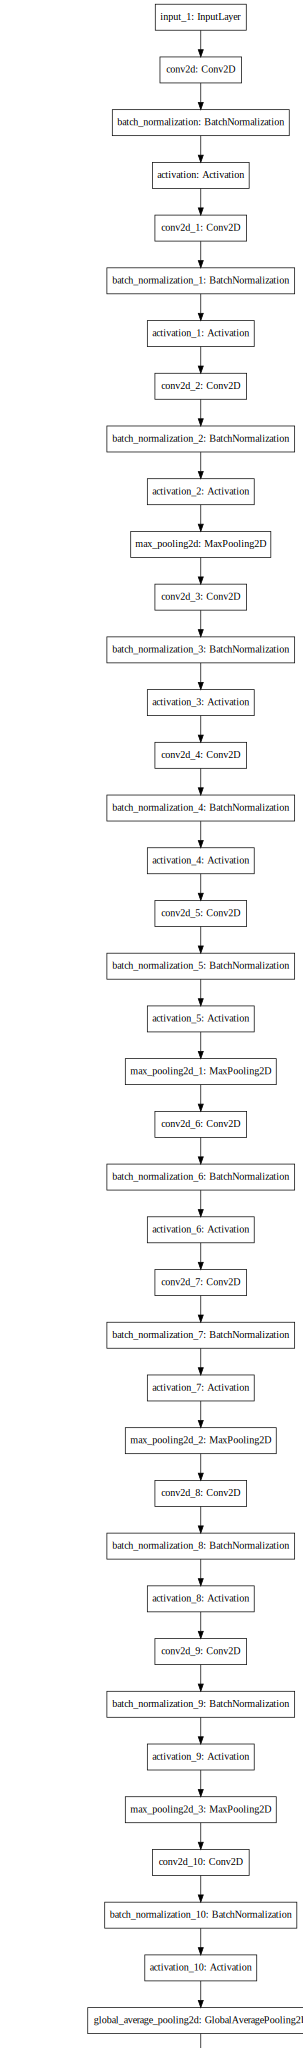

In [11]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
annotations_dir = "VOC2007/ImageSets/Main"
resimler_dir = "VOC2007/JPEGImages"
classes = ["boat","cow","cat"]
xml_ann_dir = "VOC2007\Annotations"

In [13]:
def resim_adlarini_don(ann_dir,classes,data="train"):
    resim_adlari_dict = dict()
    for sinif in classes:
        with open(ann_dir+"/"+sinif+"_"+data+".txt",mode="r",encoding="utf-8") as dosya:
            satirlar = dosya.readlines()
            resim_adlari = [x.split()[0] for x in satirlar if x.split()[1] == '1']
            resim_adlari_dict[sinif] = resim_adlari
    return resim_adlari_dict

In [15]:
def resimleri_etiketleri_ve_sinirlari_don(resim_adlari_dict,yukseklik,genislik,kanal_sayisi):
    resim_sayisi = sum([len(x) for x in resim_adlari_dict.values()])
    resimler = np.empty((resim_sayisi,yukseklik,genislik,kanal_sayisi))
    etiketler = np.empty((resim_sayisi,1))
    indis = 0
    parser = voc.XmlParser()
    sinirlar = np.empty((resim_sayisi,4))
    for i,(sinif,resim_adlari) in enumerate(resim_adlari_dict.items()):
        temp_array = np.empty((len(resim_adlari),yukseklik,genislik,kanal_sayisi))
        temp_sinir = np.empty((len(resim_adlari),4))
        for j,resim_adi in enumerate(resim_adlari):
            temp = cv2.imread(resimler_dir+"/"+resim_adi+".jpg")
            temp = cv2.resize(temp,(yukseklik,genislik))
            temp_array[j] = temp
            data = parser.load(xml_ann_dir+"/"+resim_adi+".xml")
            w = float(data["size"]["width"])
            h = float(data["size"]["height"])
            w_c = genislik/w
            h_c = uzunluk/h
            for obje in data["object"]:
                if obje["name"] in classes:
                    bnd = obje["bndbox"]
                    temp_sinir[j] = np.array([float(bnd["xmin"])*w_c,float(bnd["ymin"])*h_c,
                                              float(bnd["xmax"])*w_c,float(bnd["ymax"])*h_c])
                    break
        resimler[indis:indis+len(resim_adlari)] = temp_array
        etiketler[indis:indis+len(resim_adlari)] = i
        sinirlar[indis:indis+len(resim_adlari)] = temp_sinir
        indis += len(resim_adlari)
    return resimler,etiketler,sinirlar

In [16]:
resim_adlari_dict_train = resim_adlarini_don(annotations_dir,classes,"train")
resim_adlari_dict_val = resim_adlarini_don(annotations_dir,classes,"trainval")

In [17]:
X_val,y_val,sinirlar_val = resimleri_etiketleri_ve_sinirlari_don(resim_adlari_dict_train,224,224,3)
X_train,y_train,sinirlar_train = resimleri_etiketleri_ve_sinirlari_don(resim_adlari_dict_val,224,224,3)

In [18]:
train_indis = np.random.permutation(X_train.shape[0])
val_indis = np.random.permutation(X_val.shape[0])

X_train = X_train[train_indis]
y_train = y_train[train_indis]

X_val = X_val[val_indis]
y_val = y_val[val_indis]

sinirlar_train = sinirlar_train[train_indis]
sinirlar_val = sinirlar_val[val_indis]

In [19]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
sinirlar_train = minmax.fit_transform(sinirlar_train)
sinirlar_val = minmax.transform(sinirlar_val)

In [20]:
mean = X_train.mean()
std = X_train.std()

X_train = (X_train-mean)/(std+1e-7)
X_val = (X_val-mean)/(std+1e-7)

In [21]:
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)

In [22]:
model.compile(optimizer="adam",loss=["categorical_crossentropy","mse"],
              loss_weights=[0.7,1],metrics=[["accuracy"],["mae"]])

In [23]:
from keras import callbacks
reduce = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=np.sqrt(0.1),patience=0,mode="min")

In [24]:
model.fit(x=X_train,y=[Y_train,sinirlar_train],epochs=35,batch_size=8,
          validation_data=(X_val,[Y_val,sinirlar_val]),callbacks=[reduce])

Epoch 1/35
83/83 [==============================] - 9s 110ms/step - loss: 0.7836 - class_loss: 0.9989 - reg_loss: 0.0844 - class_accuracy: 0.6055 - reg_mae: 0.2362 - val_loss: 2.7254 - val_class_loss: 3.7758 - val_reg_loss: 0.0823 - val_class_accuracy: 0.5815 - val_reg_mae: 0.2225
Epoch 2/35
83/83 [==============================] - 7s 89ms/step - loss: 0.6922 - class_loss: 0.9101 - reg_loss: 0.0551 - class_accuracy: 0.6085 - reg_mae: 0.1908 - val_loss: 0.7334 - val_class_loss: 0.9274 - val_reg_loss: 0.0842 - val_class_accuracy: 0.6422 - val_reg_mae: 0.2201
Epoch 3/35
83/83 [==============================] - 7s 89ms/step - loss: 0.6439 - class_loss: 0.8456 - reg_loss: 0.0520 - class_accuracy: 0.6237 - reg_mae: 0.1843 - val_loss: 1.2297 - val_class_loss: 1.6208 - val_reg_loss: 0.0952 - val_class_accuracy: 0.6422 - val_reg_mae: 0.2454
Epoch 4/35
83/83 [==============================] - 7s 89ms/step - loss: 0.6202 - class_loss: 0.8137 - reg_loss: 0.0507 - class_accuracy: 0.6525 - reg_mae: 

In [25]:
tahminler = model.predict(X_val)

In [26]:
tahmin_class = tahminler[0]
tahmin_bound = tahminler[1]

In [27]:
tahmin_class = tahmin_class.argmax(axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


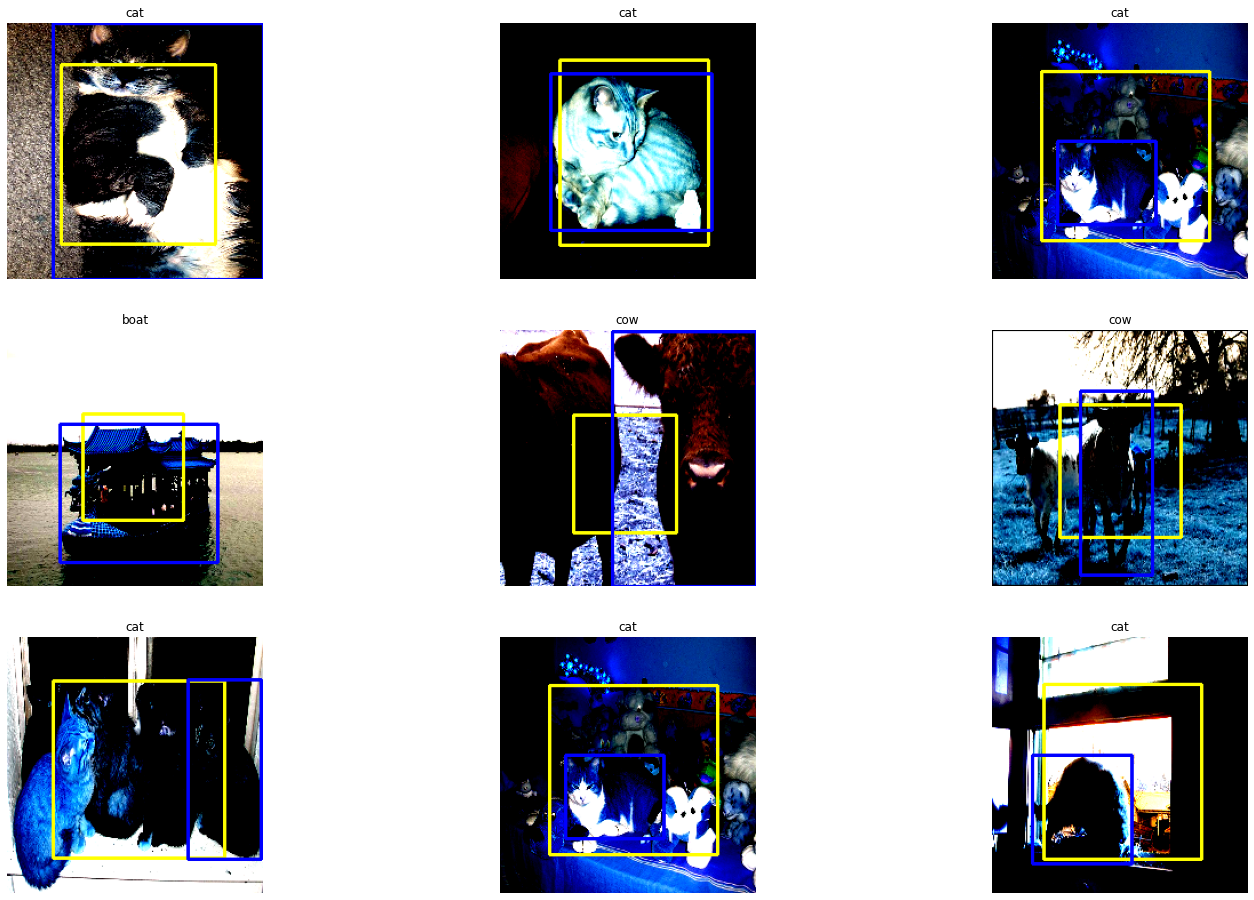

In [28]:
fig,ax = plt.subplots(3,3,figsize=(25,16))
ran = np.random.randint(0,X_val.shape[0],9)
for i in range(3):
    ax[i,0].axis("off")
    for j in range(3):
        indis = ran[3*i+j]
        res = X_val[indis].copy()
        #xmin_g,ymin_g,xmax_g,ymax_g = [int(x*224) for x in sinirlar_val[indis]]
        xmin_g,ymin_g,xmax_g,ymax_g = [int(x) for x in minmax.inverse_transform(sinirlar_val[indis:indis+1])[0]]
        sinirlar = minmax.inverse_transform(tahmin_bound[indis:indis+1])
        xmin_tahmin,ymin_tahmin,xmax_tahmin,ymax_tahmin = int(sinirlar[0,0]),int(sinirlar[0,1]),int(sinirlar[0,2]),int(sinirlar[0,3])
        a = cv2.rectangle(res,(xmin_tahmin,ymin_tahmin),(xmax_tahmin,ymax_tahmin),(255,255,0),2)
        a = cv2.rectangle(a,(xmin_g,ymin_g),(xmax_g,ymax_g),(0,0,255),2)
        ax[i,j].axis("off")
        ax[i,j].imshow(a)
        ax[i,j].set_title(classes[tahmin_class[indis]])
        #print(classes[tahmin_class[indis]])
        indis+=1
plt.show()